In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [13]:
df = pd.read_csv('filtered_energydata.csv')

In [14]:
df.head()

,Appliances,Press_mm_hg,RH_3,RH_8,RH_9,T3,T4,T8,T_out,Tdewpoint,hour
0,60.0,735.933333,44.730000,48.900000,45.53,19.79,19.000000,18.2,6.600000,5.3,17
1,60.0,735.933333,44.790000,48.863333,45.56,19.79,19.000000,18.2,6.483333,5.2,17
2,50.0,735.933333,44.933333,48.730000,45.50,19.79,18.926667,18.2,6.366667,5.1,17
3,50.0,735.933333,45.000000,48.590000,45.40,19.79,18.890000,18.1,6.250000,5.0,17
4,60.0,735.933333,45.000000,48.590000,45.40,19.79,18.890000,18.1,6.133333,4.9,17


In [15]:
df = df.rename(columns = {'RH_3': 'Laundry_Humidity', 'RH_8': 'Teenager_Room_Humidity', 'RH_9': 'Parents_Room_Humidity',
                          'T3': 'Laundry_Temperature','T4':'Office_Temperature', 'T8': 'Teenager_Room_Temperature', 'T9': 'Parents_Room_Temperature',
                          'T_out': 'Outside_Temperature', 'Tdewpoint': 'Dew_Point_Temperature'})
df.head()  

,Appliances,Press_mm_hg,Laundry_Humidity,Teenager_Room_Humidity,Parents_Room_Humidity,Laundry_Temperature,Office_Temperature,Teenager_Room_Temperature,Outside_Temperature,Dew_Point_Temperature,hour
0,60.0,735.933333,44.730000,48.900000,45.53,19.79,19.000000,18.2,6.600000,5.3,17
1,60.0,735.933333,44.790000,48.863333,45.56,19.79,19.000000,18.2,6.483333,5.2,17
2,50.0,735.933333,44.933333,48.730000,45.50,19.79,18.926667,18.2,6.366667,5.1,17
3,50.0,735.933333,45.000000,48.590000,45.40,19.79,18.890000,18.1,6.250000,5.0,17
4,60.0,735.933333,45.000000,48.590000,45.40,19.79,18.890000,18.1,6.133333,4.9,17


In [16]:
df.shape    

(19735, 11)

In [17]:
X = df.drop(['Appliances'], axis=1)
y = df['Appliances']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("knn", KNeighborsRegressor())
])

In [57]:
param_grid = {
    "knn__n_neighbors": range(1, 30),
    "knn__p": [1, 1.5, 2, 3],
    "knn__weights": ["uniform", "distance"]
}   

In [58]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",    
    cv=5, 
    n_jobs=-1, 
    verbose=2   
)

In [59]:
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Fitting 5 folds for each of 232 candidates, totalling 1160 fits
Best parameters: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV score: -570.2350732064031


In [60]:
best_knn = grid_search.best_estimator_

# Evaluate  the model 
test_score = best_knn.score(x_test, y_test) 
print("Test Score:", test_score)

Test Score: 0.7401195194839718


In [61]:
prediction = best_knn.predict(x_test)

In [62]:
# Evaluating the model
mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, prediction)

In [63]:
print(f"Mean Absolute Error (MAE): {mae:.2f} Wh")
print(f"Mean Squared Error (MSE): {mse:.2f} Wh²")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Wh")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 13.89 Wh
Mean Squared Error (MSE): 486.79 Wh²
Root Mean Squared Error (RMSE): 22.06 Wh
R² Score: 0.74


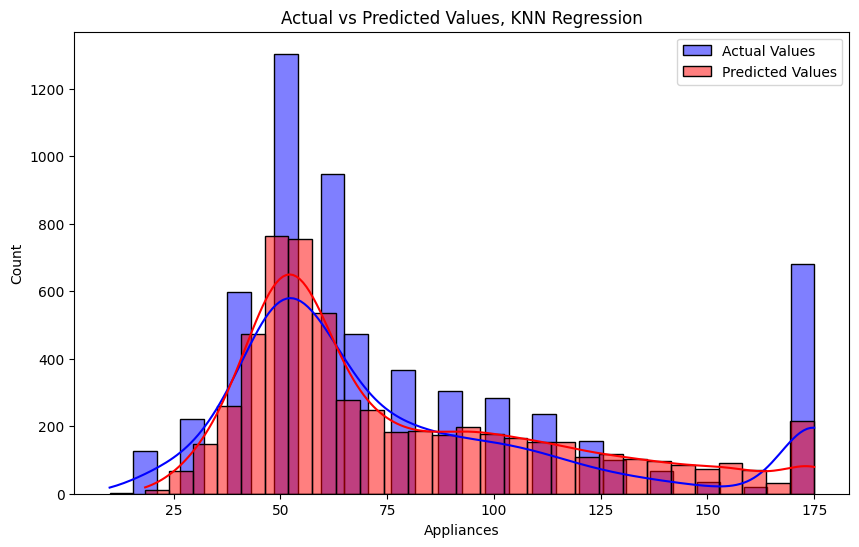

In [66]:
# Visualizing the predictions vs the actual values  
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Values')
sns.histplot(prediction, kde=True, color='red', label='Predicted Values')
plt.title('Actual vs Predicted Values, KNN Regression')
plt.legend()
plt.show()  

## <span style="color: #20C997;">Personal Analysis</span>
I trained both models on the same dataset, and the results were quite different. KNN fits the data more accurately than Linear Regression.<br> Linear Regression struggled with the peaks near 50 and 175,  KNN does better overall but still misses some peaks.
To further improve KNN, <br>I can try a few things. First, I might focus on tuning the number of neighbors in a small range. I could also play with different distance metrics.